# CNN-BiLSTM-CRF

This notebook is based on the work of "End-to-end Sequence Labelling via Bidirectional LSTM-CNNs-CRF https://arxiv.org/pdf/1603.01354.pdf

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, concatenate, Embedding, Dense, TimeDistributed, InputSpec, Dropout, Bidirectional, Layer, Conv1D, SpatialDropout1D,GlobalMaxPooling1D, Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow_addons.text import crf_decode, crf_log_likelihood

# from keras_contrib.losses import crf_loss
# from keras_contrib.metrics import crf_accuracy

from tf2crf import CRF, ModelWithCRFLoss, ModelWithCRFLossDSCLoss

import nltk
nltk.download('punkt')

from termcolor import colored

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thevindegamboda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [211]:
def load_data(file_path):
    file = open(file_path, "r")
    data, entities, sentence, unique_labels = [], [], [], []
    for line in file:
        line = line.strip("\n").split("\t")
        
        if len(line) > 1:
            word = line[0]
            label = line[1]
            
            sentence.append(word)
            entities.append(label)
            
            if label not in unique_labels:
                unique_labels.append(label)
            
        elif len(entities) > 0:
            sentence = " ".join(sentence)
            data.append({"sentence" : sentence, "entities" : entities})
            entities, sentence = [], []
            
    file.close()
    return data, unique_labels

In [212]:
train_dev_filepath = "data/NERdata/NCBI-disease/train_dev.tsv"
test_filepath = "data/NERdata/NCBI-disease/test.tsv"

train_data, train_unq_labels = load_data(train_dev_filepath)
test_data, _ = load_data(test_filepath)

data = train_data + test_data

In [213]:
data[0]

{'sentence': 'Identification of APC2 , a homologue of the adenomatous polyposis coli tumour suppressor .',
 'entities': ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B',
  'I',
  'I',
  'I',
  'O',
  'O']}

In [214]:
#Check how many datapoints and unique labels we have acquired from the dataset

len(data), len(train_unq_labels)

(7287, 3)

In [215]:
#Now we will make reference dictionaries for the text elements

def get_mappings(data, word_ent):

    if word_ent == "word" or word_ent == "char":
        vocab = Counter([i for x in data for i in x['sentence'].split()])
        if word_ent == "char":
            vocab = Counter([i for x in vocab for i in list(x)])
    elif word_ent == "ent":
        vocab = Counter([i for x in data for i in x['entities']])
    
    vocab = [i[0] for i in vocab.most_common()]
    
    idx2tok = {idx:tok for idx, tok in enumerate(vocab, 1)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab, 1)}
    
    return tok2idx, idx2tok


word2idx, idx2word = get_mappings(data, "word")
char2idx, idx2char = get_mappings(data, "char")
tag2idx, idx2tag = get_mappings(data, "ent")

n_words = len(word2idx)
n_chars = len(char2idx)

In [216]:
# We will add a PAD token to consider padding during training

word2idx["UNK"] = n_words + 1
idx2word[n_words + 1] = "UNK"

word2idx["PAD"] = 0
idx2word[0] = "PAD"

char2idx["UNK"] = n_chars + 1
idx2char[n_chars + 1] = "UNK"

char2idx["PAD"] = 0
idx2char[0] = "PAD"

# tag2idx["PAD"] = 0
# idx2tag[0] = "PAD"


assert len(word2idx) == len(idx2word) and len(char2idx) == len(idx2char)

In [217]:
tag2idx

{'O': 1, 'I': 2, 'B': 3}

In [218]:
tag2idx = {i:x for x, i in enumerate(tag2idx.keys())}
idx2tag = {i:x for x, i in tag2idx.items()}

In [219]:
tag2idx, idx2tag

({'O': 0, 'I': 1, 'B': 2}, {0: 'O', 1: 'I', 2: 'B'})

In [220]:
n_words = len(word2idx)
n_chars = len(char2idx)

print("There are {} unique words/elements in the corpus being considered".format(n_words))

There are 10820 unique words/elements in the corpus being considered


For convenience let us create a Pandas df summarising all the relevant data to this point

In [221]:
columns = ["Sentence", "Labels", "Word Tokens", "Label Tokens", "Character Tokens"]

data_df = []
for i in range(len(data)):
    #We want data in the form : [Sentence, Labels, Words Tokens, Label Tokens]
    sentence = data[i]['sentence']
    labels = data[i]['entities']
    words = sentence.split()
    chars = [list(i) for i in words]
    word_tkns = [word2idx.get(i) for i in words]
    label_tkns = [tag2idx.get(i) for i in labels]
    char_tkns = [list(map(char2idx.get, i)) for i in chars]
    
    data_df.append([sentence, labels, word_tkns, label_tkns, char_tkns])
    
data_df = pd.DataFrame(data_df, columns = columns)

In [222]:
data_df.head()

,Sentence,Labels,Word Tokens,Label Tokens,Character Tokens
0,"Identification of APC2 , a homologue of the ad...","[O, O, O, O, O, O, O, O, B, I, I, I, O, O]","[777, 3, 2888, 4, 8, 778, 3, 2, 335, 280, 532,...","[0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 0, 0]","[[37, 11, 1, 4, 6, 2, 20, 2, 10, 3, 6, 2, 5, 4..."
1,The adenomatous polyposis coli ( APC ) tumour ...,"[O, B, I, I, I, I, I, I, O, O, O, O, O, O, O, ...","[18, 335, 280, 532, 10, 115, 9, 507, 6, 355, 3...","[0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[[34, 17, 1], [3, 11, 1, 4, 5, 13, 3, 6, 5, 14..."
2,Complex formation induces the rapid degradatio...,"[O, O, O, O, O, O, O, O, O]","[4814, 623, 3363, 2, 1036, 2889, 3, 3362, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[[24, 5, 13, 12, 9, 1, 32], [20, 5, 7, 13, 3, ..."
3,"In colon carcinoma cells , loss of APC leads t...","[O, B, I, O, O, O, O, O, O, O, O, O, O, O, O, ...","[51, 1577, 578, 84, 4, 160, 3, 115, 872, 11, 2...","[0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[37, 4], [10, 5, 9, 5, 4], [10, 3, 7, 10, 2, ..."
4,"Here , we report the identification and genomi...","[O, O, O, O, O, O, O, O, O, O, O, O, O]","[368, 4, 54, 149, 2, 397, 7, 197, 517, 3, 115,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[43, 1, 7, 1], [63], [44, 1], [7, 1, 12, 5, 7..."


<BarContainer object of 3 artists>

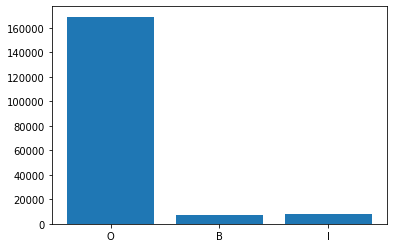

In [223]:
from collections import Counter

labels = [i for x in data_df["Labels"].values for i in x]
cnt = Counter(labels)
plt.bar(cnt.keys(), cnt.values())

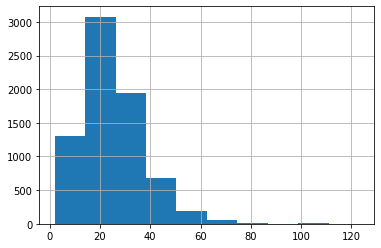

count    7287.000000
mean       25.273364
std        12.583760
min         2.000000
25%        17.000000
50%        23.000000
75%        32.000000
max       123.000000
Name: Word Tokens, dtype: float64

In [224]:
lengths = data_df['Word Tokens'].map(len)

lengths.hist()
plt.show()

lengths.describe()

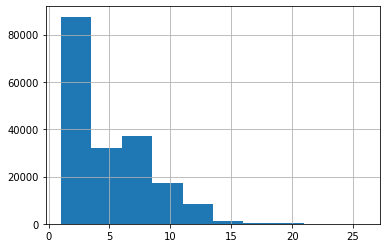

count    184167.000000
mean          4.682104
std           3.334064
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max          26.000000
dtype: float64

In [225]:
words = data_df["Character Tokens"]
word_lengths = pd.Series([len(x) for i in words for x in i])

word_lengths.hist()
plt.show()

word_lengths.describe()

In [226]:
MAX_CHAR = 26
MAX_WORD = 123

padded_sentences = pad_sequences(data_df["Word Tokens"], maxlen=MAX_WORD, dtype='int32', padding='post', truncating='post', value= word2idx["PAD"])
padded_labels = pad_sequences(data_df["Label Tokens"], maxlen = MAX_WORD, dtype='int32', padding='post', truncating='post', value= tag2idx["O"])
padded_labels = np.array([to_categorical(i, num_classes = len(tag2idx)) for i in padded_labels])
padded_chars = [pad_sequences(x, maxlen = MAX_CHAR, dtype = 'int32', padding = 'post', truncating = 'post', value= char2idx["PAD"]) for x in data_df["Character Tokens"]]
padded_chars = pad_sequences(padded_chars, maxlen = MAX_WORD, padding = 'post', value = [0]*MAX_CHAR)

no_samples = np.shape(padded_sentences)[0]

In [227]:
idx = list(range(no_samples))

train_idx, val_test_idx = train_test_split(idx, test_size = 0.6, shuffle = True, random_state = 2021)
val_idx, test_idx = train_test_split(val_test_idx, test_size = 0.5)

train_sent, train_chars, train_labels = padded_sentences[train_idx], padded_chars[train_idx], padded_labels[train_idx]
val_sent, val_chars, val_labels = padded_sentences[val_idx], padded_chars[val_idx], padded_labels[val_idx]
test_sent, test_chars, test_labels = padded_sentences[test_idx], padded_chars[test_idx], padded_labels[test_idx]

## Build Model

In [228]:
def get_model(word_vocab_size, char_vocab_size, max_word_len, max_char_len, final_layer = 'softmax', lr = 0.001):
    WORD_EMB_DIM = 64
    CHAR_EMB_DIM = 64

    # Input and Embedding for words
    word_input = Input(shape = (max_word_len,))
    word_emb = Embedding(input_dim=word_vocab_size + 1, output_dim=WORD_EMB_DIM, trainable = True,
                         input_length=max_word_len, mask_zero = True, name = "word_embed")(word_input)
    
    
    
    # Input and Embedding for characters
    char_input= Input(shape = (max_word_len, max_char_len,))
    char_emb = TimeDistributed(Embedding(input_dim = char_vocab_size + 1, output_dim = CHAR_EMB_DIM, trainable = True,
                                        input_length = max_char_len, name = "char_embed"))(char_input)
    
    
    # Character CNN feature extraction with filter of length 3
    char_conv = TimeDistributed(Conv1D(32, 4, padding='same'), name = "td_conv1d")(char_emb)
    char_pool = TimeDistributed(GlobalMaxPooling1D(), name="char_pooling")(char_conv)
    
    # Main LSTM
    x = concatenate([word_emb, char_pool])
    #x = SpatialDropout1D(0.3)(x)
    main_lstm = Bidirectional(LSTM(units=32, return_sequences=True, dropout = 0.5, recurrent_dropout = 0.5), name = 'bilstm')(x)
    
    opt = Nadam(lr=lr, clipnorm = 1.0)
    input_nodes = [word_input, char_input]
    
    if final_layer == 'softmax':
        out = TimeDistributed(Dense(len(tag2idx), activation="softmax"), name = 'tdd')(main_lstm)
        model = Model(input_nodes, out)
        model.compile(loss = "categorical_crossentropy", optimizer=opt)
    
    elif final_layer == 'crf':
        
        crf = CRF(units = len(tag2idx))

        out = crf(main_lstm)

        base_model = Model(input_nodes, out)
        model = ModelWithCRFLoss(base_model, sparse_target=False)

        model.compile(optimizer=opt)
    
    try:
        model.summary()
    except:
        pass
    
    return model

In [229]:
classifier = 'softmax'

model = get_model(len(word2idx), len(char2idx), MAX_WORD, MAX_CHAR, final_layer = classifier, lr = 0.001)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 123, 26)]    0                                            
__________________________________________________________________________________________________
time_distributed_4 (TimeDistrib (None, 123, 26, 64)  5632        input_10[0][0]                   
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 123)]        0                                            
__________________________________________________________________________________________________
td_conv1d (TimeDistributed)     (None, 123, 26, 32)  8224        time_distributed_4[0][0]         
____________________________________________________________________________________________

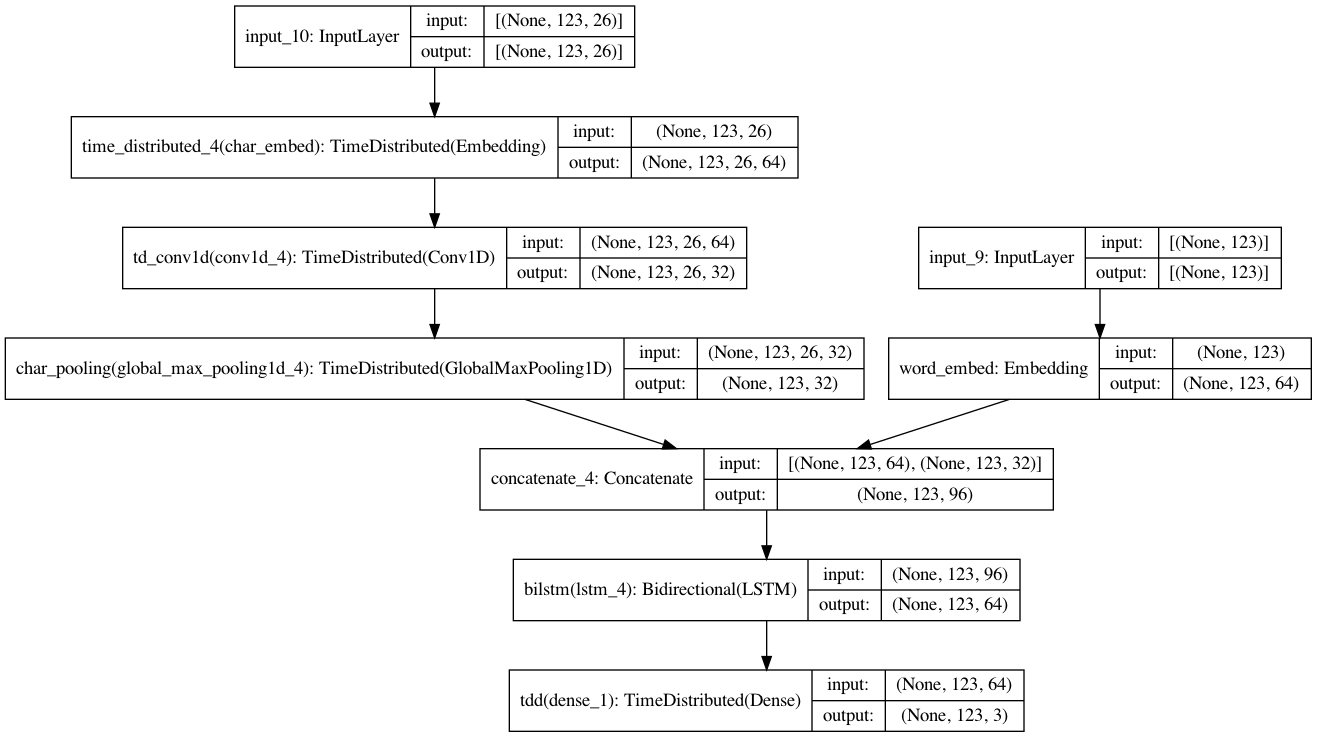

In [230]:
image_filepath = "docs/char_softmax.png"

plot_model(model, to_file = image_filepath, show_shapes = True)

In [231]:
file_path = "saved_model_params/{}.h5".format(classifier)
BATCH_SIZE = 16
MAX_EPOCHS = 15

monitored_metric = "val_loss"

if classifier == "crf":
    monitored_metric += "_val"

checkpoint = ModelCheckpoint(file_path, monitor=monitored_metric, verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor=monitored_metric, mode='min', verbose=1, patience=5)
reduce_ = ReduceLROnPlateau(monitor=monitored_metric, mode='min', patience=3, min_lr=1e-6)

history = model.fit(x = [train_sent, train_chars], y = train_labels, validation_data = ([val_sent, val_chars], val_labels),
                   batch_size = BATCH_SIZE, epochs = MAX_EPOCHS, callbacks=[es, checkpoint, reduce_], verbose = 1)

Epoch 1/15
183/183 [==============================] - 40s 186ms/step - loss: 0.0964 - val_loss: 0.0340

Epoch 00001: val_loss improved from inf to 0.03398, saving model to saved_model_params/softmax.h5
Epoch 2/15
183/183 [==============================] - 34s 187ms/step - loss: 0.0313 - val_loss: 0.0223

Epoch 00002: val_loss improved from 0.03398 to 0.02234, saving model to saved_model_params/softmax.h5
Epoch 3/15
183/183 [==============================] - 34s 187ms/step - loss: 0.0183 - val_loss: 0.0195

Epoch 00003: val_loss improved from 0.02234 to 0.01945, saving model to saved_model_params/softmax.h5
Epoch 4/15
183/183 [==============================] - 35s 190ms/step - loss: 0.0144 - val_loss: 0.0177

Epoch 00004: val_loss improved from 0.01945 to 0.01773, saving model to saved_model_params/softmax.h5
Epoch 5/15
183/183 [==============================] - 35s 191ms/step - loss: 0.0119 - val_loss: 0.0170

Epoch 00005: val_loss improved from 0.01773 to 0.01704, saving model to save

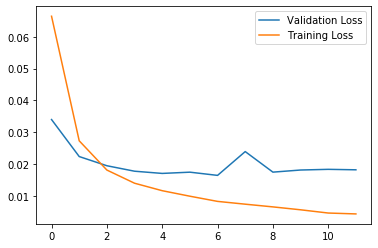

In [232]:
plt.plot(history.history[monitored_metric], label = "Validation Loss")
plt.plot(history.history['loss'], label = "Training Loss")
plt.legend(loc = "best")

## Evaluation

In [233]:
loss = model.evaluate([test_sent, test_chars], test_labels)

69/69 [==============================] - 3s 39ms/step - loss: 0.0208


In [234]:
preds = model.predict([test_sent, test_chars])

In [236]:
print(classification_report([np.argmax(idx2tag[x]) for i in preds for x in i], [idx2tag[np.argmax(i)] for x in test_labels for i in x], labels = ["B", "I"]))

TypeError: unhashable type: 'numpy.ndarray'

In [237]:
i = 345
if classifier == 'softmax':
    p = np.argmax(preds[i], axis=-1)
else:
    p = preds[i]
print("{:20}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(test_sent[i], np.argmax(test_labels[i], axis = -1), p):
    if w != 0:
        print("{:20}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word                ||True ||Pred
High                : O     O
-                   : O     O
resolution          : O     O
banding             : O     O
analysis            : O     O
showed              : O     O
an                  : O     O
interstitial        : O     O
deletion            : O     O
of                  : O     O
the                 : O     O
long                : O     O
arm                 : O     O
of                  : O     O
chromosome          : O     O
5                   : O     O
(                   : O     O
q22                 : O     O
.                   : O     O
1                   : O     O
-                   : O     O
-                   : O     O
-                   : O     O
-                   : O     O
q31                 : O     O
1                   : O     O
-                   : O     O
-                   : O     O
-                   : O     O
-                   : O     O
q31                 : O     O
.                   : O     O
1     

In [238]:
%%bash

ls

README.md
data
docs
model.ipynb
models
recent_works
saved_model_params
utils


## Evaluation on Medical Transcription Data

In [239]:
med_trans = pd.read_csv("data/mtsamples.csv")

In [240]:
surgery_trans = med_trans.loc[med_trans['medical_specialty'] == " Surgery"]

In [241]:
surgery_trans.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
174,174,Austin & Youngswick bunionectomy with Biopro ...,Surgery,Youngswick Bunionectomy,"PREOPERATIVE DIAGNOSES:,1. Hallux rigidus, le...","surgery, hallux rigidus, metatarsal, youngswic..."
177,177,"This patient has undergone cataract surgery, ...",Surgery,YAG Laser Capsulotomy - 1,"PREOPERATIVE DIAGNOSIS: , Secondary capsular m...","surgery, abraham capsulotomy, yag, yag laser c..."
179,179,Youngswick osteotomy with internal screw fixa...,Surgery,Youngswick Osteotomy,"TITLE OF OPERATION: , Youngswick osteotomy wit...","surgery, hallux limitus deformity, metatarsoph..."
181,181,Wound debridement with removal of Surgisis xe...,Surgery,Wound Debridement,"PREOPERATIVE DIAGNOSES,1. Open wound from rig...","surgery, open wound, prosthetic vascular graft..."
182,182,Visually significant posterior capsule opacit...,Surgery,YAG Laser Capsulotomy,"PREOPERATIVE DIAGNOSIS:, Visually significant...","surgery, capsule opacity, yag, ophthalmic, yag..."


In [242]:
text = surgery_trans['transcription'].values

In [243]:
text[1]

'PREOPERATIVE DIAGNOSIS: , Secondary capsular membrane, right eye.,POSTOPERATIVE DIAGNOSIS: , Secondary capsular membrane, right eye.,PROCEDURE PERFORMED: , YAG laser capsulotomy, right eye.,INDICATIONS: , This patient has undergone cataract surgery, and vision is reduced in the operated eye due to presence of a secondary capsular membrane.  The patient is being brought in for YAG capsular discission.,PROCEDURE: , The patient was seated at the YAG laser, the pupil having been dilated with 1%  Mydriacyl, and Iopidine was instilled.  The Abraham capsulotomy lens was then positioned and applications of laser energy in the pattern indicated on the outpatient note were applied.  A total of'

In [244]:
class NER:
    def __init__(self, text, classifier):
        self.sent = text
        self.classifier = classifier
        self.preds = []
        self.test_words = []
        self.test_chars = []
        
    def build_data(self):
        text = tokenize.sent_tokenize(self.sent)
        word_tokens = []
        char_tokens = []
        for sent in text:
            words = sent.split()
            chars = [list(i) for i in words]
            word_tkns = [word2idx.get(i, word2idx["UNK"]) for i in words]
            char_tkns = [list(map(lambda x: char2idx.get(x, char2idx["UNK"]), i)) for i in chars]

            word_tokens.append(word_tkns)
            char_tokens.append(char_tkns)
            
        self.test_words = pad_sequences(word_tokens, maxlen=MAX_WORD, dtype='int32', padding='post', truncating='post', value= word2idx["PAD"])
        test_chars = [pad_sequences(x, maxlen = MAX_CHAR, dtype = 'int32', padding = 'post', truncating = 'post', value= char2idx["PAD"]) for x in char_tokens]
        self.test_chars = pad_sequences(test_chars, maxlen = MAX_WORD, padding = 'post', value = [0]*MAX_CHAR)
        
        return self.test_words, self.test_chars
    
    def predict(self):
        if self.test_words == []:
            self.build_data()
        self.preds = model.predict([self.test_words, self.test_chars])
        
        return self.preds
    
    def pretty_print(self):
        if self.preds == []:
            self.predict()
        preds = self.preds
        text = tokenize.sent_tokenize(self.sent)
        for x in range(len(preds)):
            tag_preds = np.argmax(preds[x], axis=-1) if self.classifier != "crf" else preds[x]
            test_sent = self.test_words[x]
            true_words = text[x].split()
            for i, (word, tag) in enumerate(zip(test_sent, tag_preds)):
                if word != 0:
                    if tag != 0:
                        output = colored(true_words[i], color='green', on_color='on_grey')
                    else:
                        output = true_words[i]

                    print(output, end = " ")

In [245]:
n = NER(text[3], classifier)
n.pretty_print()

PREOPERATIVE DIAGNOSES,1. Open wound from right axilla to abdomen with a prosthetic vascular graft, possibly infected.,2. Diabetes.,3. Peripheral vascular disease.,POSTOPERATIVE DIAGNOSES,1. Open wound from right axilla to abdomen with a prosthetic vascular graft, possibly infected.,2. Diabetes.,3. Peripheral vascular disease.,OPERATIONS,1. Wound debridement with removal of Surgisis xenograft and debridement of skin and subcutaneous tissue.,2. Secondary closure of wound, complicated.,3. VAC insertion.,DESCRIPTION OF PROCEDURE:, After obtaining an informed consent, the patient was brought to the operating room where a general anesthetic was given. A time-out process was followed. All the staples holding the xenograft were removed as well as all the dressings and the area was prepped with Betadine soap and then painted with Betadine solution and draped in usual fashion.,The xenograft was not adhered at all and was easily removed. There was some, what appeared to be a seropurulent exudate